<a href="https://colab.research.google.com/github/Jvlia17/brain-tumor-classification/blob/main/Krebs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
# Necessary imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Collecting data

In [2]:
# Delete existing folders
!rm -rf sample_data
!rm -rf /content/Krebs.zip?dl=0
!rm -rf /content/testing
!rm -rf /content/training
!rm -rf /content/validation
!rm -rf /content/Krebs.zip?dl=0
!rm -rf /content/bestmodel.h5
!rm -rf /content/Krebs
!rm -rf /content/logs
!rm -rf /content/effnet.h5


# Get the data and unzip it
!wget https://www.dropbox.com/s/qi7t4v6mzjeps6b/Krebs.zip?dl=0
!unzip /content/Krebs.zip?dl=0

Streaming output truncated to the last 5000 lines.
  inflating: Krebs/Training/glioma/Image (453).jpg  
  inflating: Krebs/Training/glioma/Image (454).jpg  
  inflating: Krebs/Training/glioma/Image (455).jpg  
  inflating: Krebs/Training/glioma/Image (456).jpg  
  inflating: Krebs/Training/glioma/Image (457).jpg  
  inflating: Krebs/Training/glioma/Image (458).jpg  
  inflating: Krebs/Training/glioma/Image (459).jpg  
  inflating: Krebs/Training/glioma/Image (46).jpg  
  inflating: Krebs/Training/glioma/Image (460).jpg  
  inflating: Krebs/Training/glioma/Image (461).jpg  
  inflating: Krebs/Training/glioma/Image (462).jpg  
  inflating: Krebs/Training/glioma/Image (463).jpg  
  inflating: Krebs/Training/glioma/Image (464).jpg  
  inflating: Krebs/Training/glioma/Image (465).jpg  
  inflating: Krebs/Training/glioma/Image (466).jpg  
  inflating: Krebs/Training/glioma/Image (467).jpg  
  inflating: Krebs/Training/glioma/Image (468).jpg  
  inflating: Krebs/Training/glioma/Image (469).jp

# 2. Preparing the data

In [3]:
data_dir = ('/content/Krebs/Training')
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
for i in categories:
    path = os.path.join(data_dir, i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))

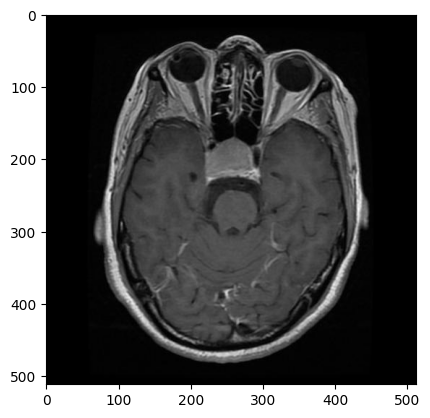

In [4]:
plt.imshow(img_array);

In [5]:
# The image shape.
img_array.shape

(512, 512, 3)

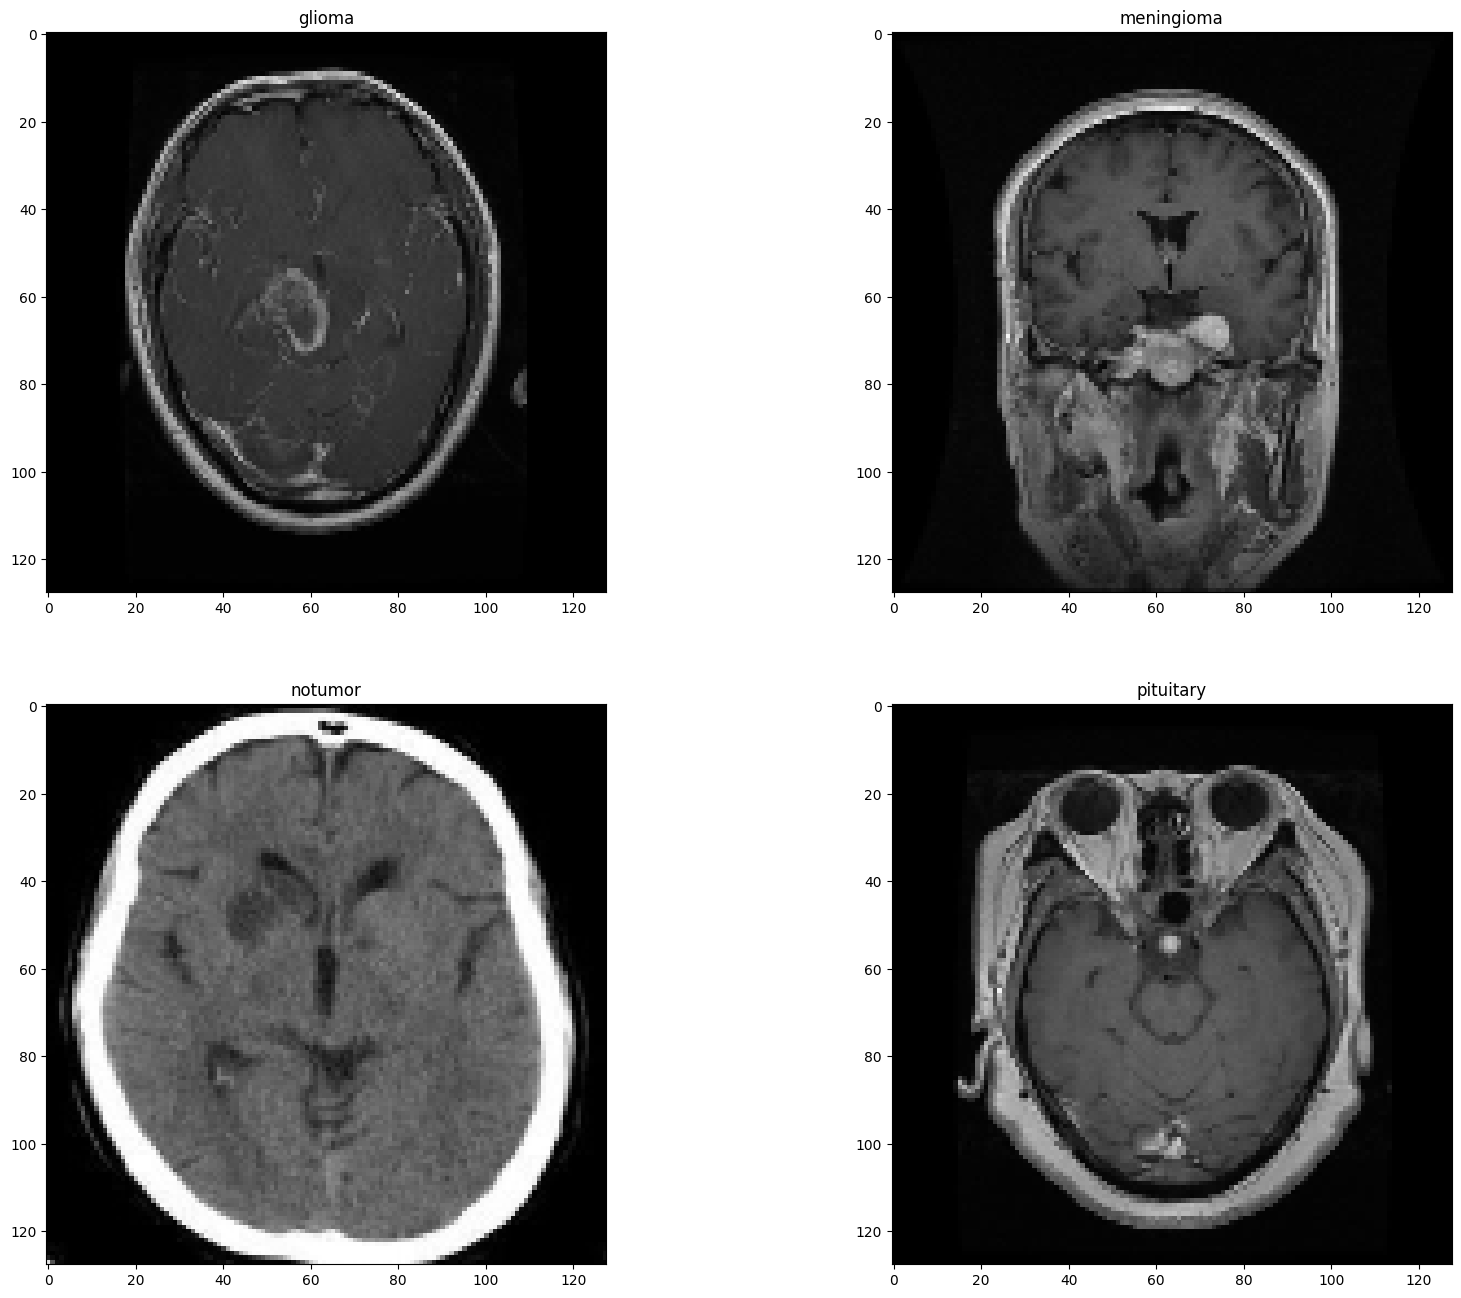

In [6]:
plt.figure(figsize=(20, 16))

images_path = ['/content/Krebs/Testing/glioma/Image (17).jpg', '/content/Krebs/Testing/meningioma/Image (200).jpg', '/content/Krebs/Testing/notumor/Image (1).jpg', '/content/Krebs/Testing/pituitary/Image (1).jpg']

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(images_path[i])
    img = cv2.resize(img, (128, 128))
    plt.imshow(img)
    plt.title(categories[i])

In [7]:
ROOT_DIR = "/content/Krebs/Testing"
number_of_images = {}

for dir in os.listdir(ROOT_DIR): # we want to know how many images we have
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('meningioma', 306), ('pituitary', 300), ('notumor', 405), ('glioma', 300)])

In [8]:
ROOT_DIR = "/content/Krebs/Training"
number_of_images = {}

for dir in os.listdir(ROOT_DIR): # we want to know how many images we have
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('meningioma', 1339), ('pituitary', 1457), ('notumor', 1595), ('glioma', 1321)])

# Data Augmentation

In [9]:
# using the ImageDataGenerator to data augmentation

generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

generator_test = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)



train = generator_train.flow_from_directory('/content/Krebs/Training', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale', shuffle=False)

test = generator_test.flow_from_directory('/content/Krebs/Testing', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale', shuffle=False)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# 3. Choosing a model

In [10]:
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32,(3,3), input_shape=(200, 200, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional layer 2
model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units= 1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=4, activation='softmax'))

model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

es = EarlyStopping(monitor = "val_loss", min_delta = 0.01, patience = 6, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor = "val_loss", filepath = "./bestmodel.h5", verbose = 1, save_best_only = True, mode = 'auto')

cd = [es, mc]

# 4. Training the model

In [11]:
import time

start = time.time()

history = model.fit(train, steps_per_epoch=5712//32, epochs=100, validation_data=test, validation_steps= 1311//32)

print("Total time: ", time.time() - start, "seconds")

Epoch 1/100
178/178 [==============================] - 29s 85ms/step - loss: 0.5213 - accuracy: 0.5044 - val_loss: 0.3787 - val_accuracy: 0.6430
Epoch 2/100
178/178 [==============================] - 14s 78ms/step - loss: 0.3751 - accuracy: 0.6585 - val_loss: 0.3518 - val_accuracy: 0.6625
Epoch 3/100
178/178 [==============================] - 13s 76ms/step - loss: 0.2809 - accuracy: 0.7377 - val_loss: 0.2531 - val_accuracy: 0.7602
Epoch 4/100
178/178 [==============================] - 14s 77ms/step - loss: 0.2386 - accuracy: 0.7993 - val_loss: 0.2791 - val_accuracy: 0.7727
Epoch 5/100
178/178 [==============================] - 14s 76ms/step - loss: 0.2068 - accuracy: 0.8296 - val_loss: 0.2162 - val_accuracy: 0.8227
Epoch 6/100
178/178 [==============================] - 14s 81ms/step - loss: 0.1775 - accuracy: 0.8556 - val_loss: 0.1798 - val_accuracy: 0.8453
Epoch 7/100
178/178 [==============================] - 14s 77ms/step - loss: 0.1473 - accuracy: 0.8900 - val_loss: 0.2428 - val_ac

# 5. Evaluating the model

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 25, 25, 128)       0

In [13]:
model.evaluate(test)

41/41 [==============================] - 2s 52ms/step - loss: 0.0758 - accuracy: 0.9847


[0.07581223547458649, 0.9847444891929626]

In [14]:
h = history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

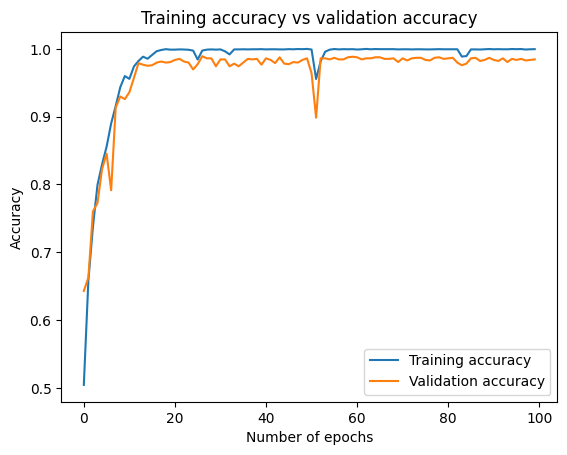

In [15]:
plt.plot(h['accuracy'], label = "Training data")
plt.plot(h['val_accuracy'], label = "Validation data")

plt.title('Training accuracy vs validation accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend(["Training accuracy", "Validation accuracy"])
plt.show()

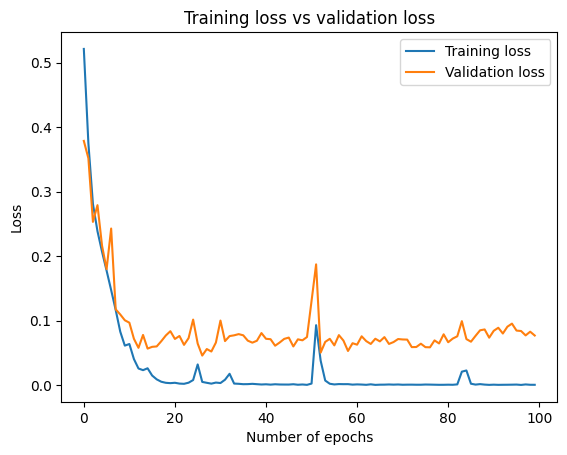

In [16]:
plt.plot(h['loss'], label = "Training data")
plt.plot(h['val_loss'], label = "Validation data")

plt.title('Training loss vs validation loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"])
plt.show()

In [17]:
from keras.models import load_model

#model = load_model("/content/bestmodel.h5")

acc = model.evaluate_generator(train)[1]
loss = model.evaluate_generator(train)[0]


print(f"The accuracy of the model is {acc*100} %")
print(f"The loss of the model is {loss*100} %")

<ipython-input-17-72bd2f1e5a66>:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(train)[1]
<ipython-input-17-72bd2f1e5a66>:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss = model.evaluate_generator(train)[0]


The accuracy of the model is 99.96498823165894 %
The loss of the model is 0.04085152177140117 %


# Confusion matrix

<ipython-input-18-1905f04b121e>:51: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test)


Confusion Matrix
Confusion matrix, without normalization
Classification Report
              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       300
  meningioma       0.97      0.96      0.97       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



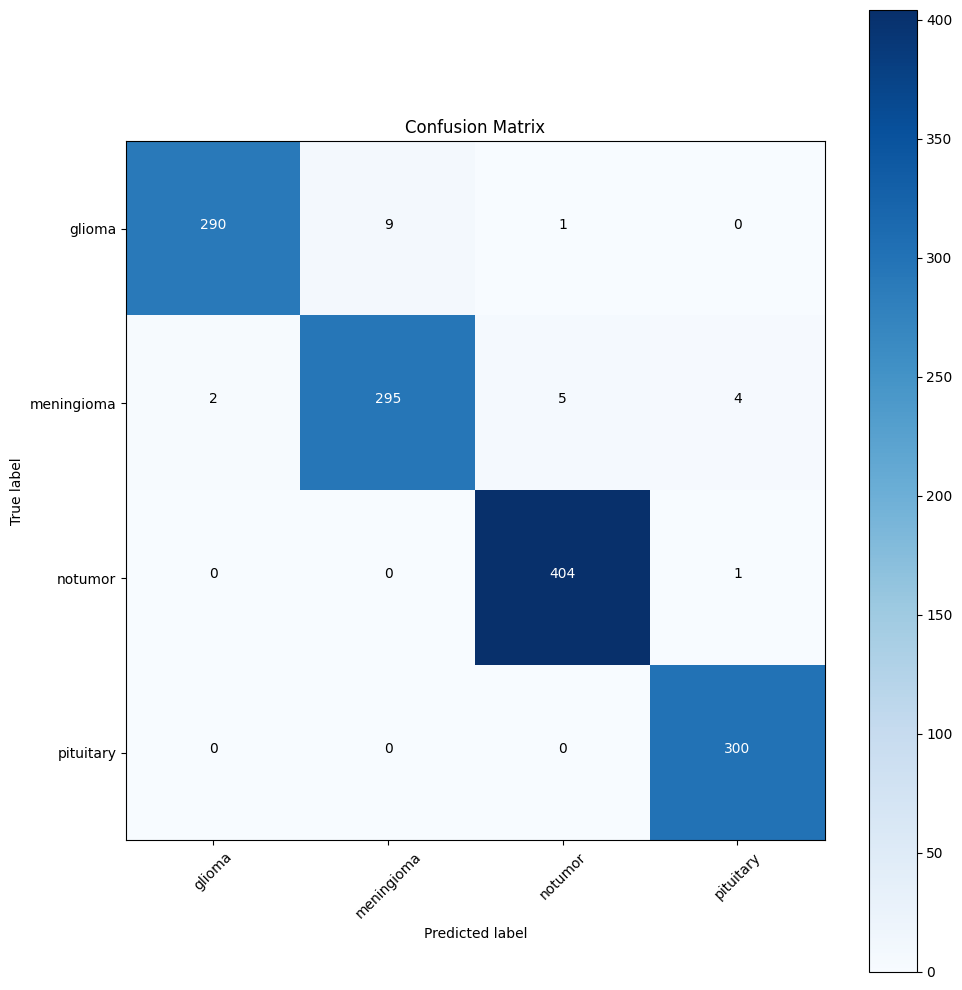

In [18]:
#Plot the confusion matrix. Set Normalize = True/False

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names

shuffle=False

target_names = []
for key in train.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix

Y_pred = model.predict_generator(test)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(test.classes, y_pred, target_names=target_names))